In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [3]:
from cell_model import CellParameters, CellModel, OCVLookupTable
from inverter import CellModelInverter

# Cell Model

Simple equivalent circuit cell model. Includes Voc that varies with SOC, internal resistance, SEI layer modeled as a paralel RC circuit.

## Equations

Voltage source and state of charge

$$
\text{SOC}(t) = \text{SOC}_0 + \frac{1}{Q} \int_{0}^{t} i_b(t) - \frac{V_{oc}(\text{SOC}(t))}{R_d} \,\text{d}t
$$

Voltage accross SEI charge transfer layer

$$
\Delta v_t(t) = \frac{1}{C_t} \int_{0}^{t} i_b(t) - \frac{\Delta v_t(t)}{R_t} \,\text{d}t
$$

Cell output

$$
v_b(t) = V_{oc}(\text{SOC}(t))\; +\; i_b(t)\, R_s\; +\; \Delta v_t(t)
$$

## System inversion

We often want to solve for $i_b(t)$ given a target power. This is implemented in real systems using PID control, however, for the purposes of simple exploration and modeling we can just use a minimizer to solve the inverse problem.

Any given $i_b(t)$ will depend on the past history of the cell so we sweep through our target powers and solve at each time step.

In [4]:
cell_params = CellParameters(
    Q=2,        # 2 Ah capacity
    Ct=2700,    # Double layer capacitance
    Rt=0.011,   # SEI layer charge transfer resistance
    Rs=0.008,   # Cell internal resistance 
    Rd=1.0e6,   # Self-discharge resistor
)

In [5]:
soc0 = 0.9     # Initial SOC

In [6]:
ocv_lu_table = OCVLookupTable(
    Voc = np.array(
        [2.25, 2.5, 3.0, 3.17, 3.225, 3.25, 3.278, 3.3, 3.31, 3.325, 3.34, 3.351, 3.354, 3.361, 3.4, 3.75]
    ),
    soc = np.array(
        [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]
    ),
)

In [7]:
ocv_lu_table.interpolate()

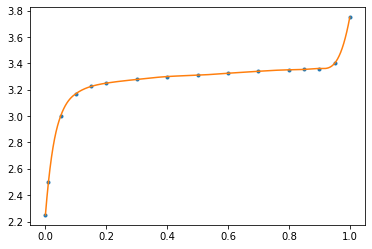

In [8]:
plt.plot(ocv_lu_table.soc, ocv_lu_table.Voc, marker='.', linestyle='None')
soc_int = np.arange(0, 1.005, 0.005)
plt.plot(soc_int, ocv_lu_table.Voc_int(soc_int))
plt.show()

In [9]:
# Target Power
time = np.arange(0, 3600, 50.0)
power = np.array([-16.0]*int(len(time)/4) + [-8.0]*int(len(time)/4) + [2.0]*int(len(time)/4) + [1.0]*int(len(time)/4))

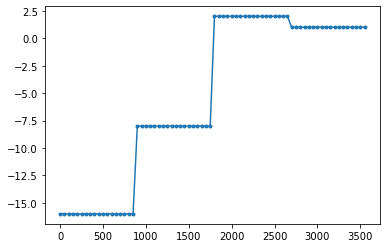

In [10]:
plt.plot(time, power, marker='.')
plt.show()

In [11]:
model_inverter = CellModelInverter(power, time, soc0, cell_params, ocv_lu_table)

In [12]:
model = model_inverter.solve()

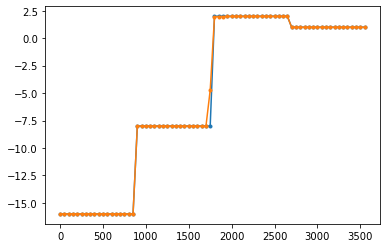

In [13]:
plt.plot(time, power, marker='.')
plt.plot(time, model.cell_power, marker='.')
plt.show()

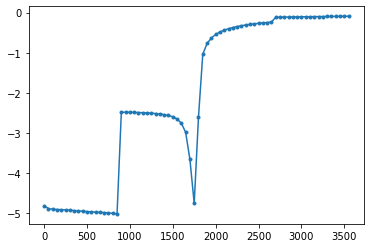

In [14]:
plt.plot(time, model.ib, marker='.');